In [1]:
import pandas as pd
import numpy as np

RSEED = 42
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')


import tensorflow as tf
tf.random.set_seed(RSEED)
from tensorflow.keras.layers import Concatenate

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score  


from survive import SurvivalData
from survive import KaplanMeier



import sys
sys.path.append('/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/AE')
import models, run_models

sys.path.append('/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/helper_functions')
import helpers, clustering_helpers


import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)





2023-11-09 09:03:34.613659: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In  models file
Using TensorFlow backend
In run_models python file


In [2]:
import warnings
warnings.filterwarnings("ignore")

### Read the datasets 

In [3]:
time_series_2d = np.load('preprocessing/representations/time_series_2d_scaled_angus.npy')
time_series_3d = np.load('preprocessing/representations/time_series_3d_scaled_angus.npy')

static = pd.read_csv('preprocessing/representations/static_eq_angus.csv')
time_series_2d_df = pd.read_csv('preprocessing/representations/time_series_2d_scaled_df_angus.csv')

In [4]:
time_series_2d.shape

(2867, 24, 48)

In [5]:
time_series_3d.shape

(2867, 24, 48)

In [6]:
time_series_2d_df = time_series_2d_df.set_index('icustay_id')

time_series_2d_df.shape

(2867, 48)

In [7]:
print('static shape before dropping empty values', static.shape)

static = static.loc[:, static.gt(0).mean() >= .1]
print('static shape after dropping empty values', static.shape)


static shape before dropping empty values (2867, 52)
static shape after dropping empty values (2867, 31)


In [8]:
static.columns

Index(['icustay_id', 'vent', 'F', 'M', 'adults', 'seniors', 'race_white',
       'gcs_13_15', 'gcs_9_12', 'gcs_<8', 'congestive_heart_failure',
       'cardiac_arrhythmias', 'hypertension', 'other_neurological',
       'chronic_pulmonary', 'diabetes_uncomplicated', 'hypothyroidism',
       'renal_failure', 'liver_disease', 'coagulopathy', 'fluid_electrolyte',
       'alcohol_abuse', 'depression', 'diabetes', 'circulatory',
       'circulatory_infectious_congenital', 'nervous_and_sense',
       'endocrinal_nutritional', 'neoplasms', 'blood_and_blood_forming',
       'mental'],
      dtype='object')

In [9]:
static = static.set_index('icustay_id')

#angus
static = static[['vent', 'F', 'M', 'adults', 'seniors', 'race_white', 'gcs_13_15',
       'gcs_9_12', 'gcs_<8', 'congestive_heart_failure', 'cardiac_arrhythmias',
       'hypertension', 'other_neurological', 'chronic_pulmonary',
       'hypothyroidism', 'renal_failure',
       'liver_disease', 'coagulopathy', 'fluid_electrolyte', 'alcohol_abuse',
       'depression', 'diabetes', 'circulatory',
       'circulatory_infectious_congenital', 'nervous_and_sense',
       'endocrinal_nutritional', 'neoplasms', 'blood_and_blood_forming',
       'mental']]
    
static.shape

(2867, 29)

In [10]:

time_series_3d = time_series_3d.astype(np.float32)
static = static.astype(float)


## Cluster

In [11]:
static = static.fillna(0)

In [12]:
## load the encoded representations

path = f'results_EQ_angus' 
latent_ts, latent_st, latent_mm = helpers.load_encoded_spaces(time_series_3d, static, 'latent_4(5)_EQ', path)
#helpers.

90/90 [==============================] - 1s 2ms/step
STATIC AE SHAPE: (2867, 4)
90/90 [==============================] - 2s 8ms/step
GRU SHAPE: (2867, 8)
90/90 [==============================] - 2s 9ms/step
MM SHAPE: (2867, 10)


In [13]:
latent_st

array([[ 0.77570206,  0.6474538 ,  2.2909427 ,  1.0253576 ],
       [ 0.6433735 ,  0.52387553,  1.4640372 ,  0.6140657 ],
       [ 0.2637287 , -0.05167626,  0.9041978 ,  2.918988  ],
       ...,
       [-0.60520184,  0.13232277,  1.5738235 ,  2.304588  ],
       [ 1.5056745 ,  1.5828748 ,  1.8697102 ,  1.3672388 ],
       [-0.4111758 , -0.3284069 ,  0.13196218,  2.2033374 ]],
      dtype=float32)

In [14]:
latent_mm

array([[-16.681318  ,  -5.540905  ,   0.63772166, ...,  -0.59757227,
         -0.65932417,  -0.15852389],
       [ -6.065711  ,  -8.061662  ,   0.9390384 , ...,   0.19888183,
         -0.8330139 ,  -0.08114136],
       [  4.066501  ,   0.1348182 ,  -0.06446799, ...,   0.46240932,
         -0.25607854,  -0.97610193],
       ...,
       [ 25.93606   ,   1.0890338 ,  -0.18313059, ...,  -0.28089574,
         -0.33282614,  -0.9915463 ],
       [-18.436829  ,  -4.971376  ,  -0.24946727, ...,  -0.90570843,
          0.03582468,  -0.08872224],
       [ 12.267031  ,   0.08979053,  -0.3633542 , ...,  -0.7127763 ,
         -0.5217474 ,  -0.99243987]], dtype=float32)


## Baselines


In [15]:
# bool_list = [True] * len(static.columns) + [False] * len(time_series_2d_df.columns) 

# #time series should be false
# best_method_baseline, best_silhouette_score_baseline, best_model_baseline, results_df_baseline, best_labels_baseline = \
#     clustering_helpers.compare_clustering_methods_baselines(static, time_series_2d_df, time_series_2d_df, bool_list, 'BASELINE', max_clusters=10)

In [16]:
# results_df_baseline

## Comparison of fusions 

KMeans
SPectral
DBSCAN
{'min_cluster_size': 49, 'min_samples': 2}
Agglomerative
The model with the maximum silhouette score is: HDBSCAN
2    516
7    494
4    482
6    458
1    449
3    174
0    156
5    138
dtype: int64
 0    2626
 1     155
-1      86
dtype: int64
2    516
7    494
4    482
6    458
1    449
3    174
0    156
5    138
dtype: int64
1    2303
0     463
2     101
dtype: int64


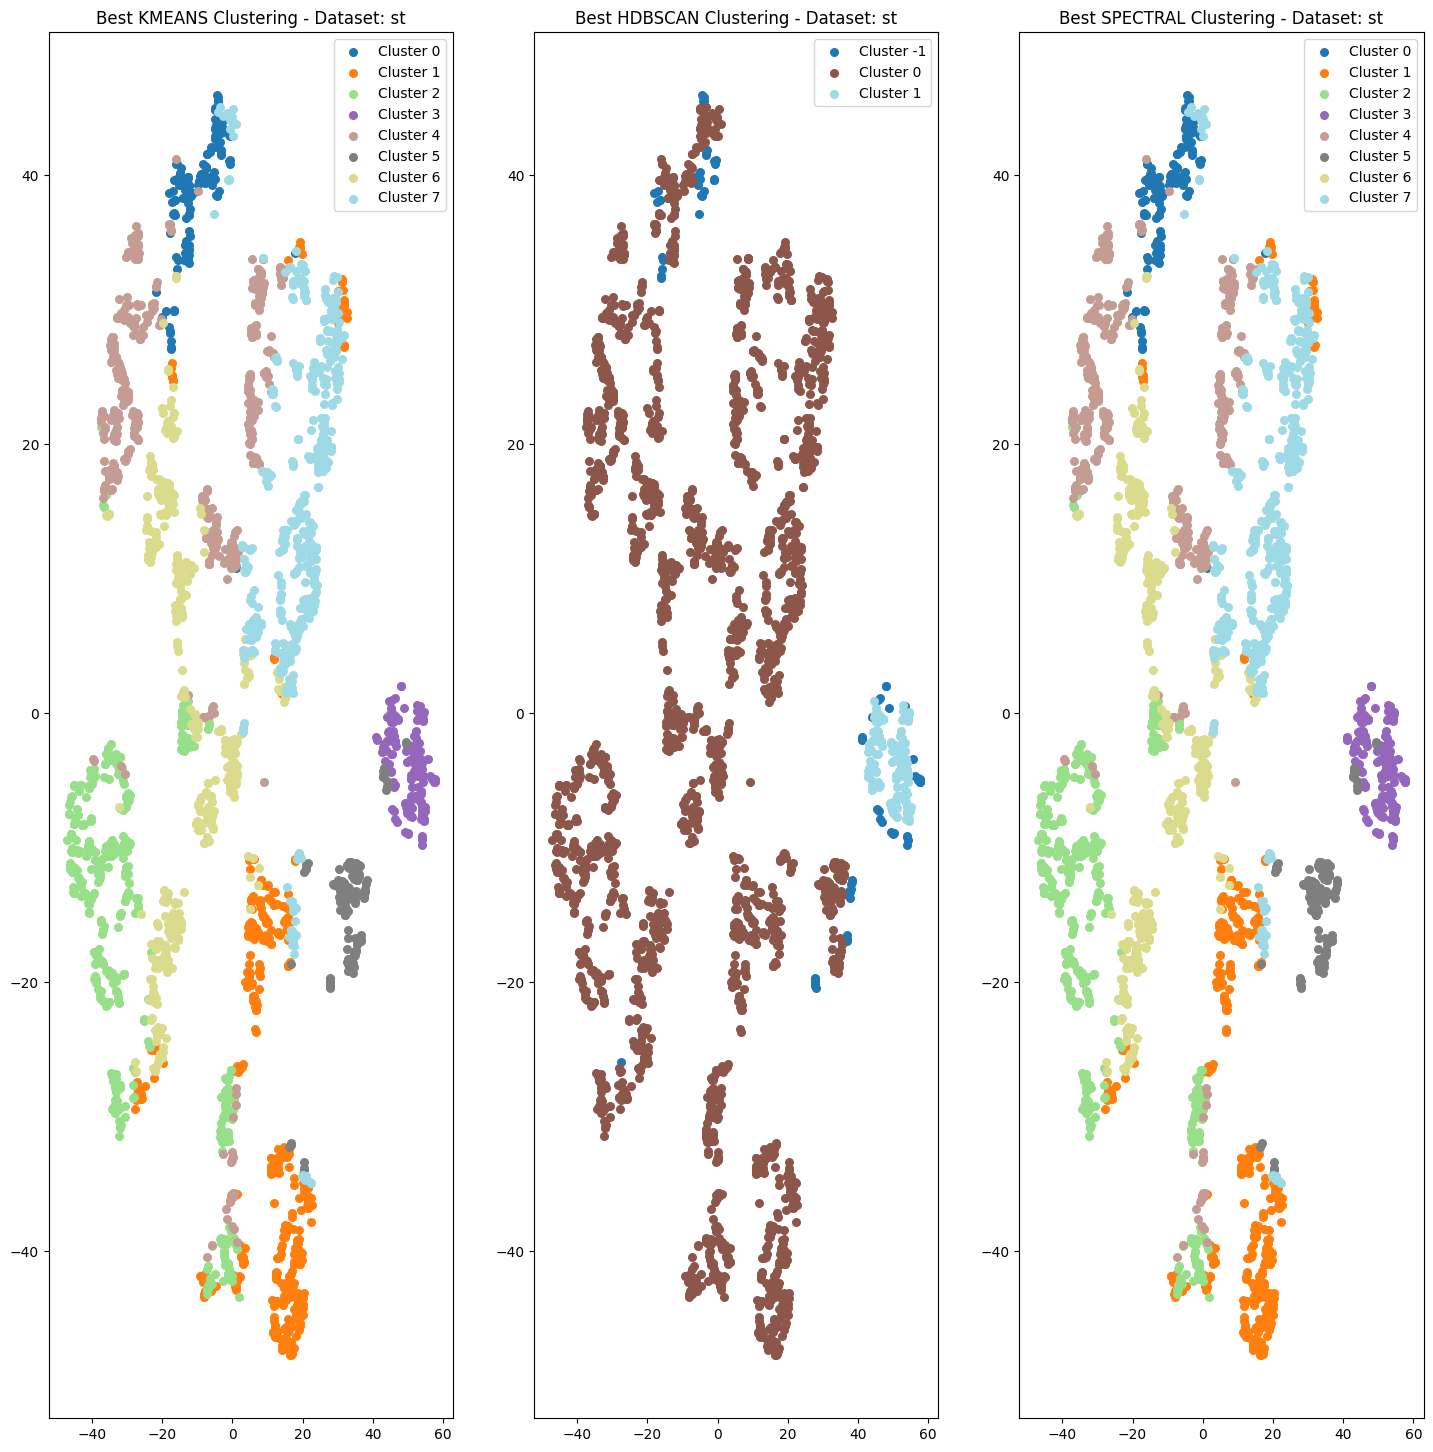

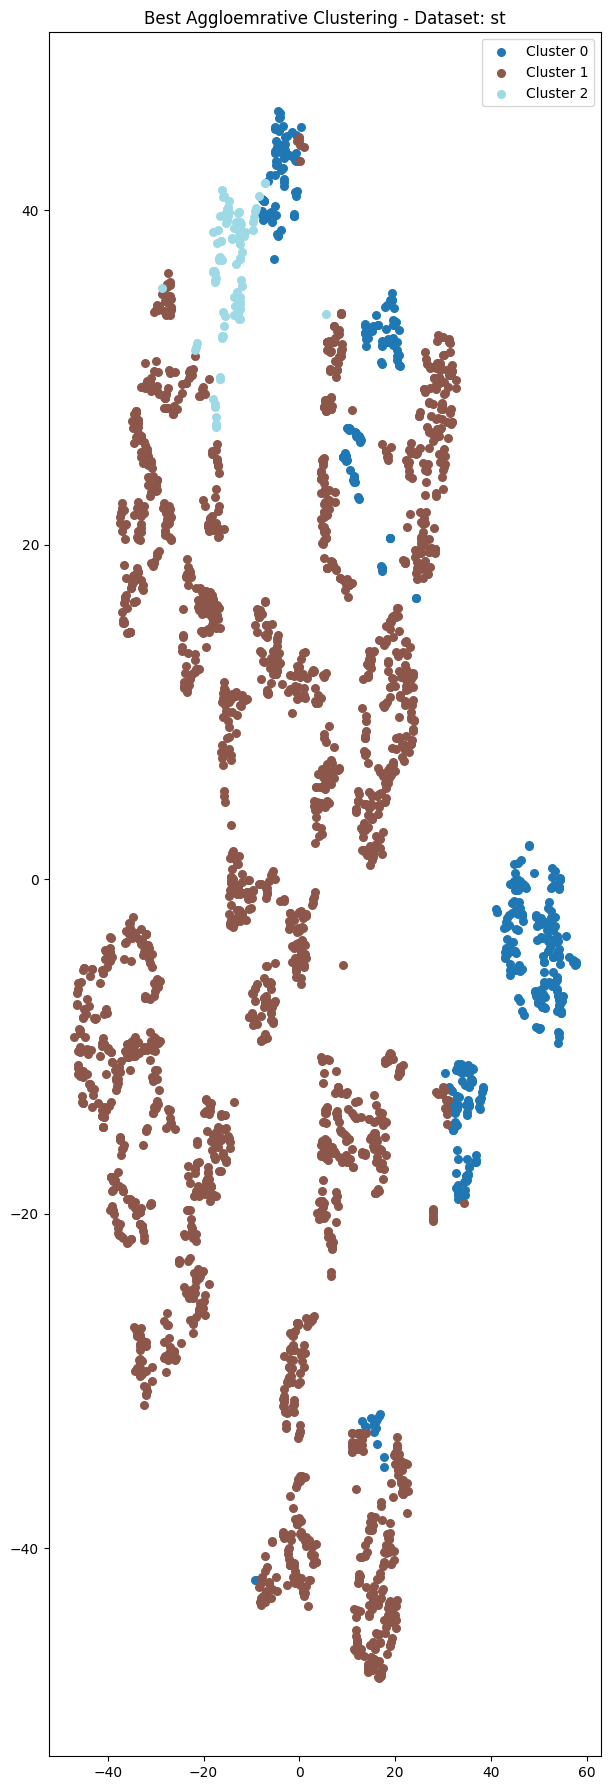

KMeans
SPectral
DBSCAN
{'min_cluster_size': 82, 'min_samples': 2}
Agglomerative
The model with the maximum silhouette score is: KMeans
1    744
4    639
3    537
0    528
2    419
dtype: int64
 1    629
 2    521
 5    416
 0    387
 6    278
 4    258
-1    256
 3    122
dtype: int64
1    744
4    639
3    537
0    528
2    419
dtype: int64
0    1527
1     789
2     551
dtype: int64


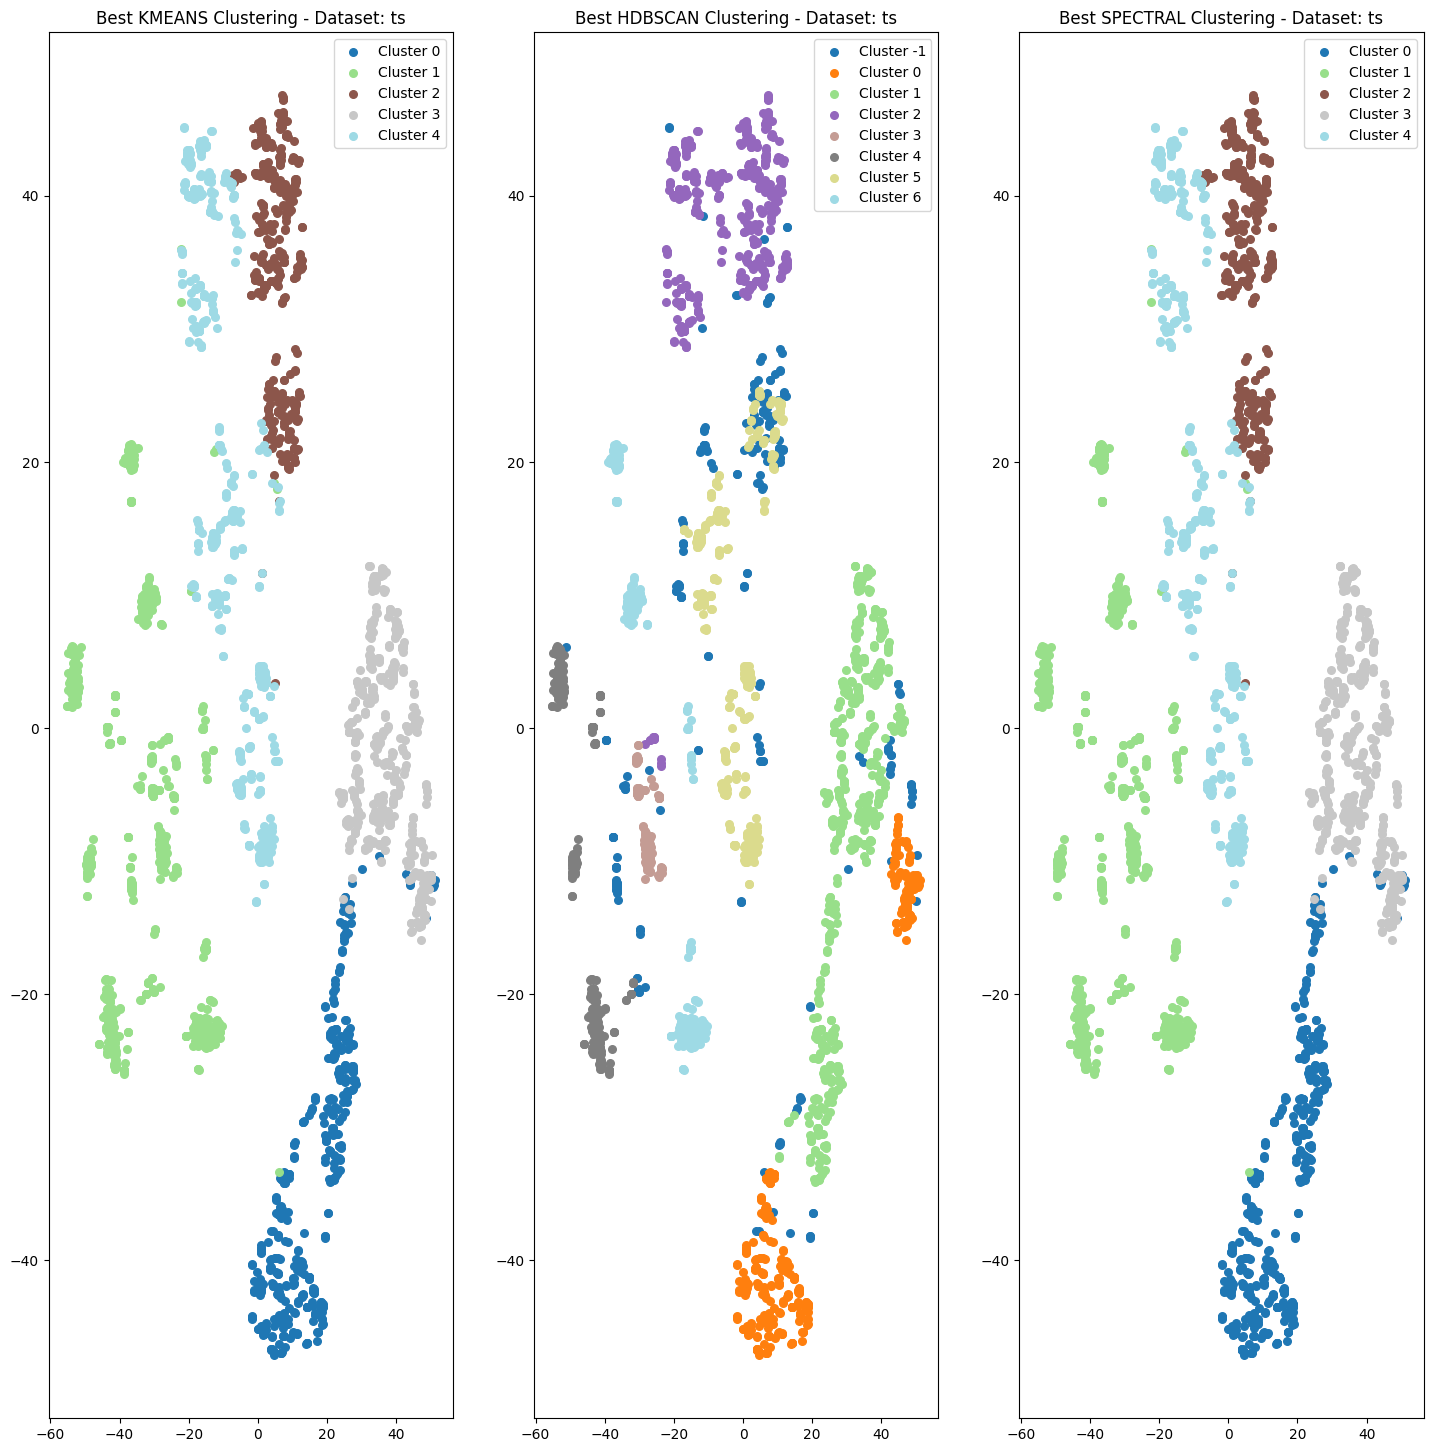

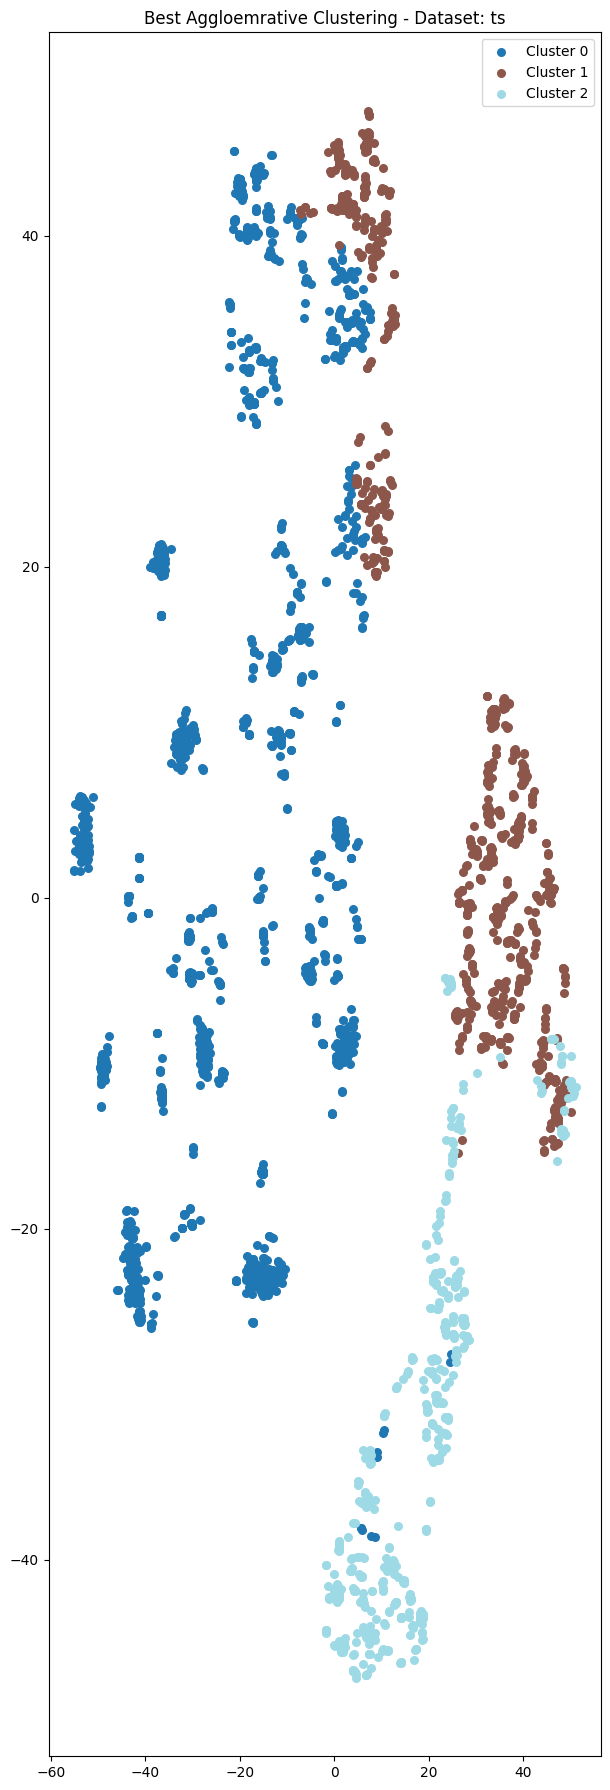

KMeans
SPectral
DBSCAN
{'min_cluster_size': 43, 'min_samples': 2}
Agglomerative
The model with the maximum silhouette score is: HDBSCAN
1    749
3    497
4    492
2    454
0    431
5    244
dtype: int64
 14    219
 12    214
 9     209
 8     208
 5     198
 20    196
 11    168
 3     163
 19    152
 2     144
 1     142
 6     109
 17    109
 7     103
-1      91
 4      80
 18     78
 10     77
 16     63
 15     50
 0      47
 13     47
dtype: int64
1    749
3    497
4    492
2    454
0    431
5    244
dtype: int64
0     641
12    362
4     341
9     213
13    206
3     191
10    171
2     156
11    108
6      98
7      92
8      80
5      73
14     48
1      47
15     40
dtype: int64


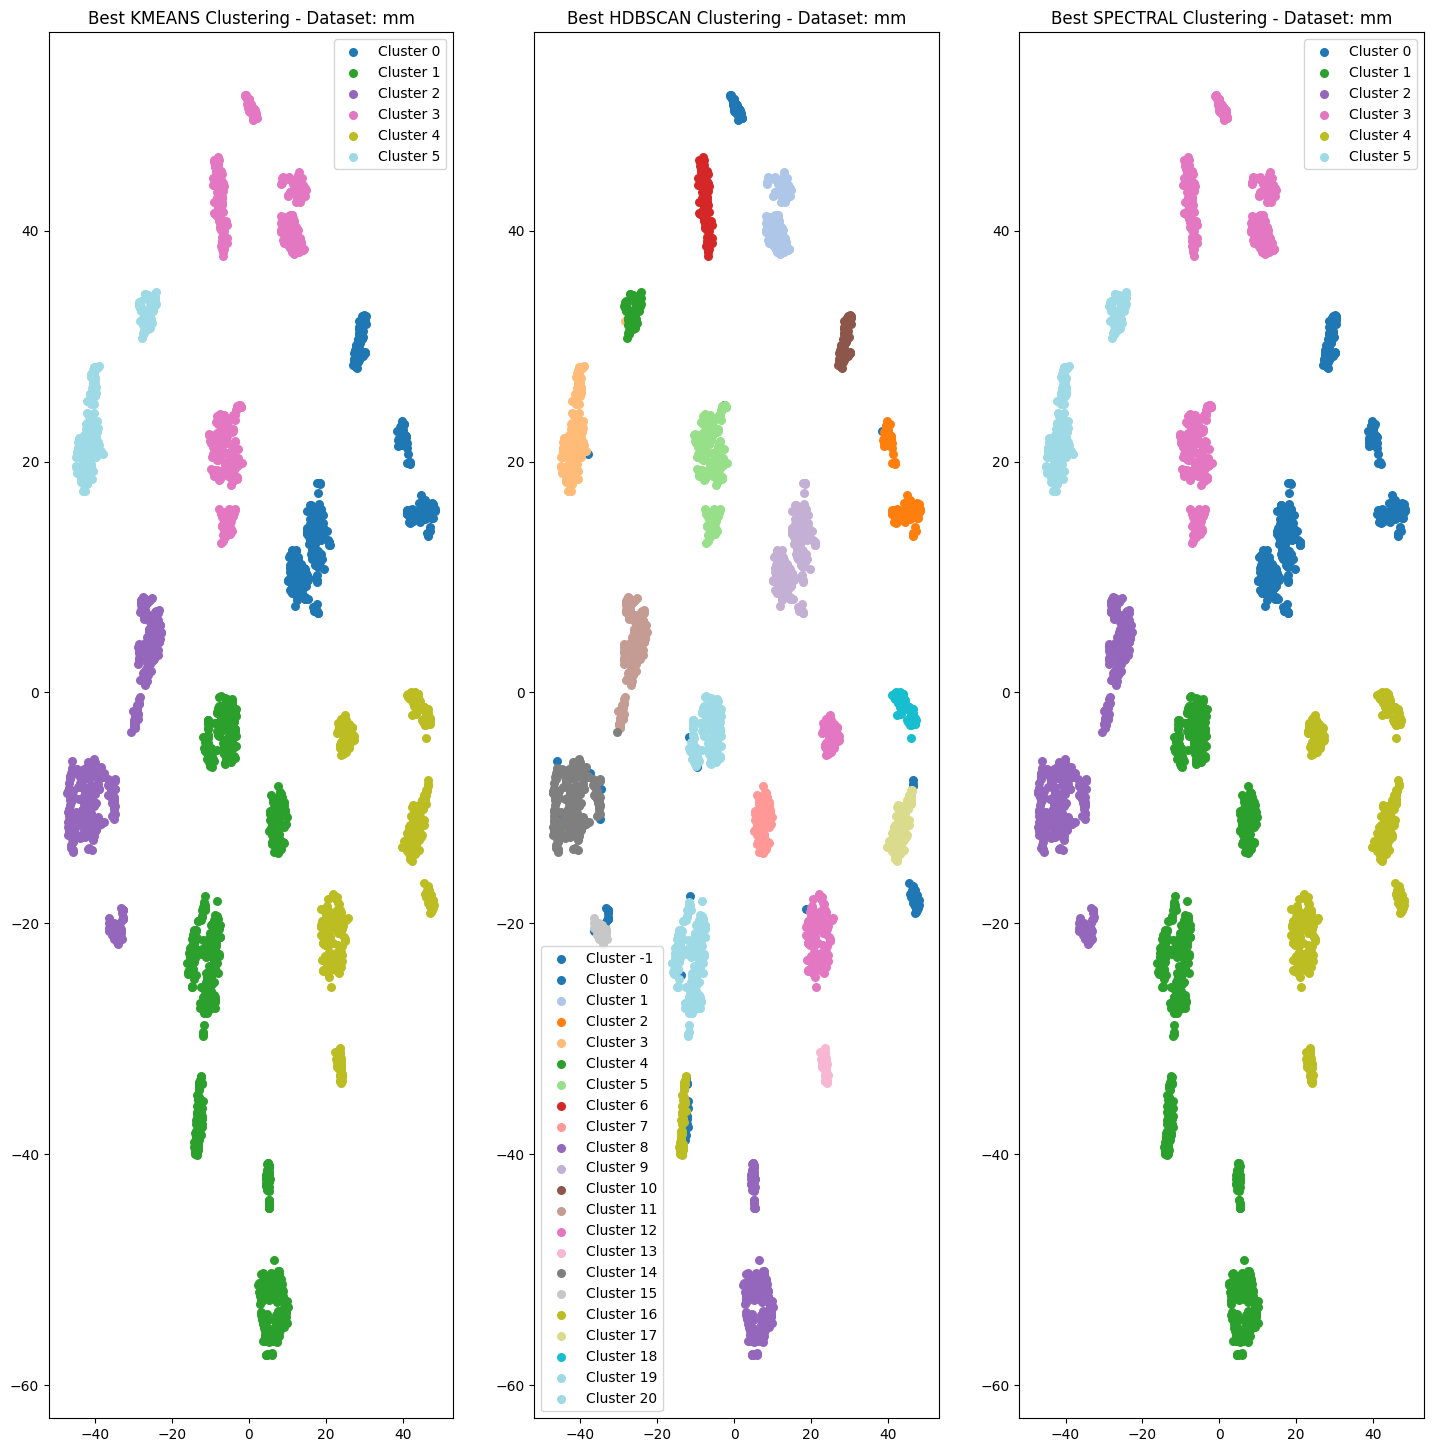

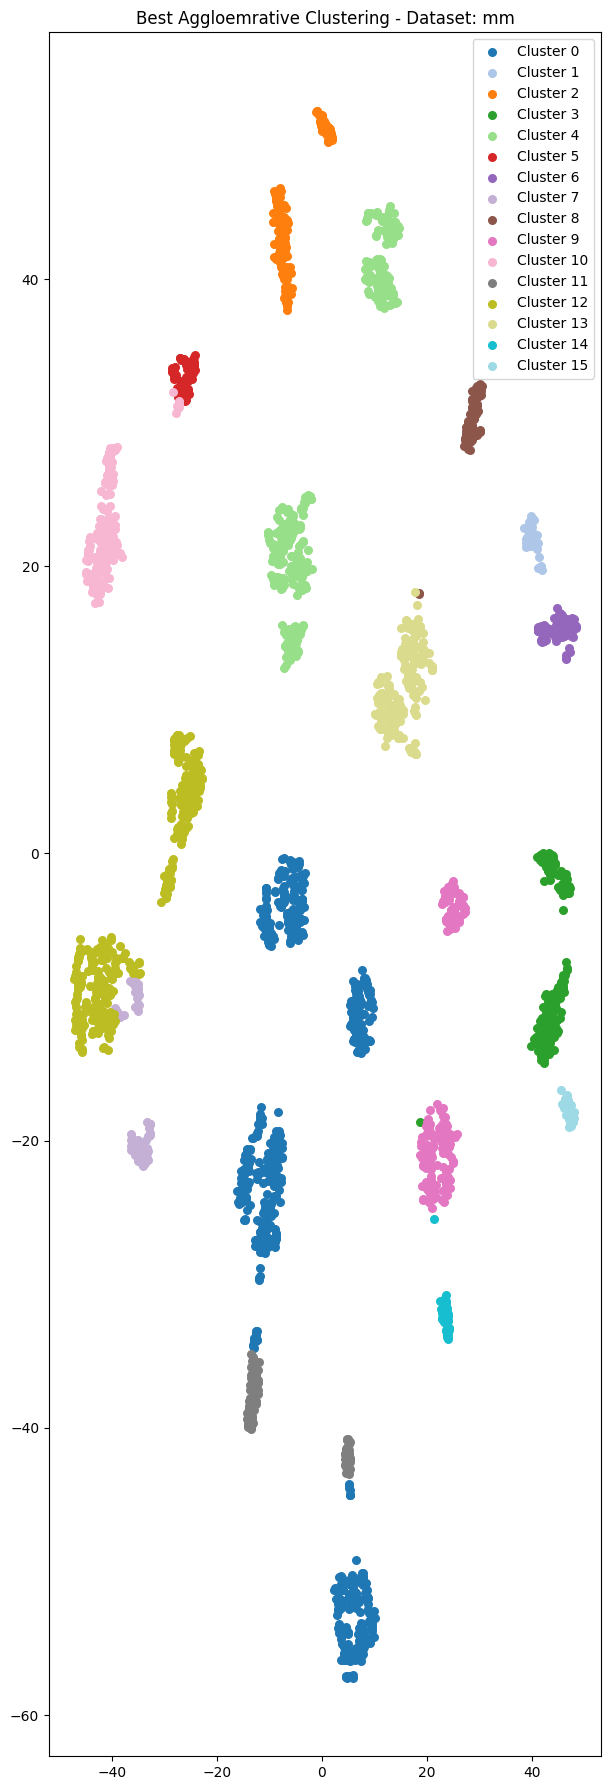

KMeans
SPectral
DBSCAN
{'min_cluster_size': 44, 'min_samples': 2}
Agglomerative
The model with the maximum silhouette score is: HDBSCAN
3    528
5    494
6    464
2    454
7    451
4    170
1    161
0    145
dtype: int64
 0    2465
-1     282
 1     120
dtype: int64
3    528
5    494
6    464
2    454
7    451
4    170
1    161
0    145
dtype: int64
0    1645
4     785
1     257
2      94
3      86
dtype: int64


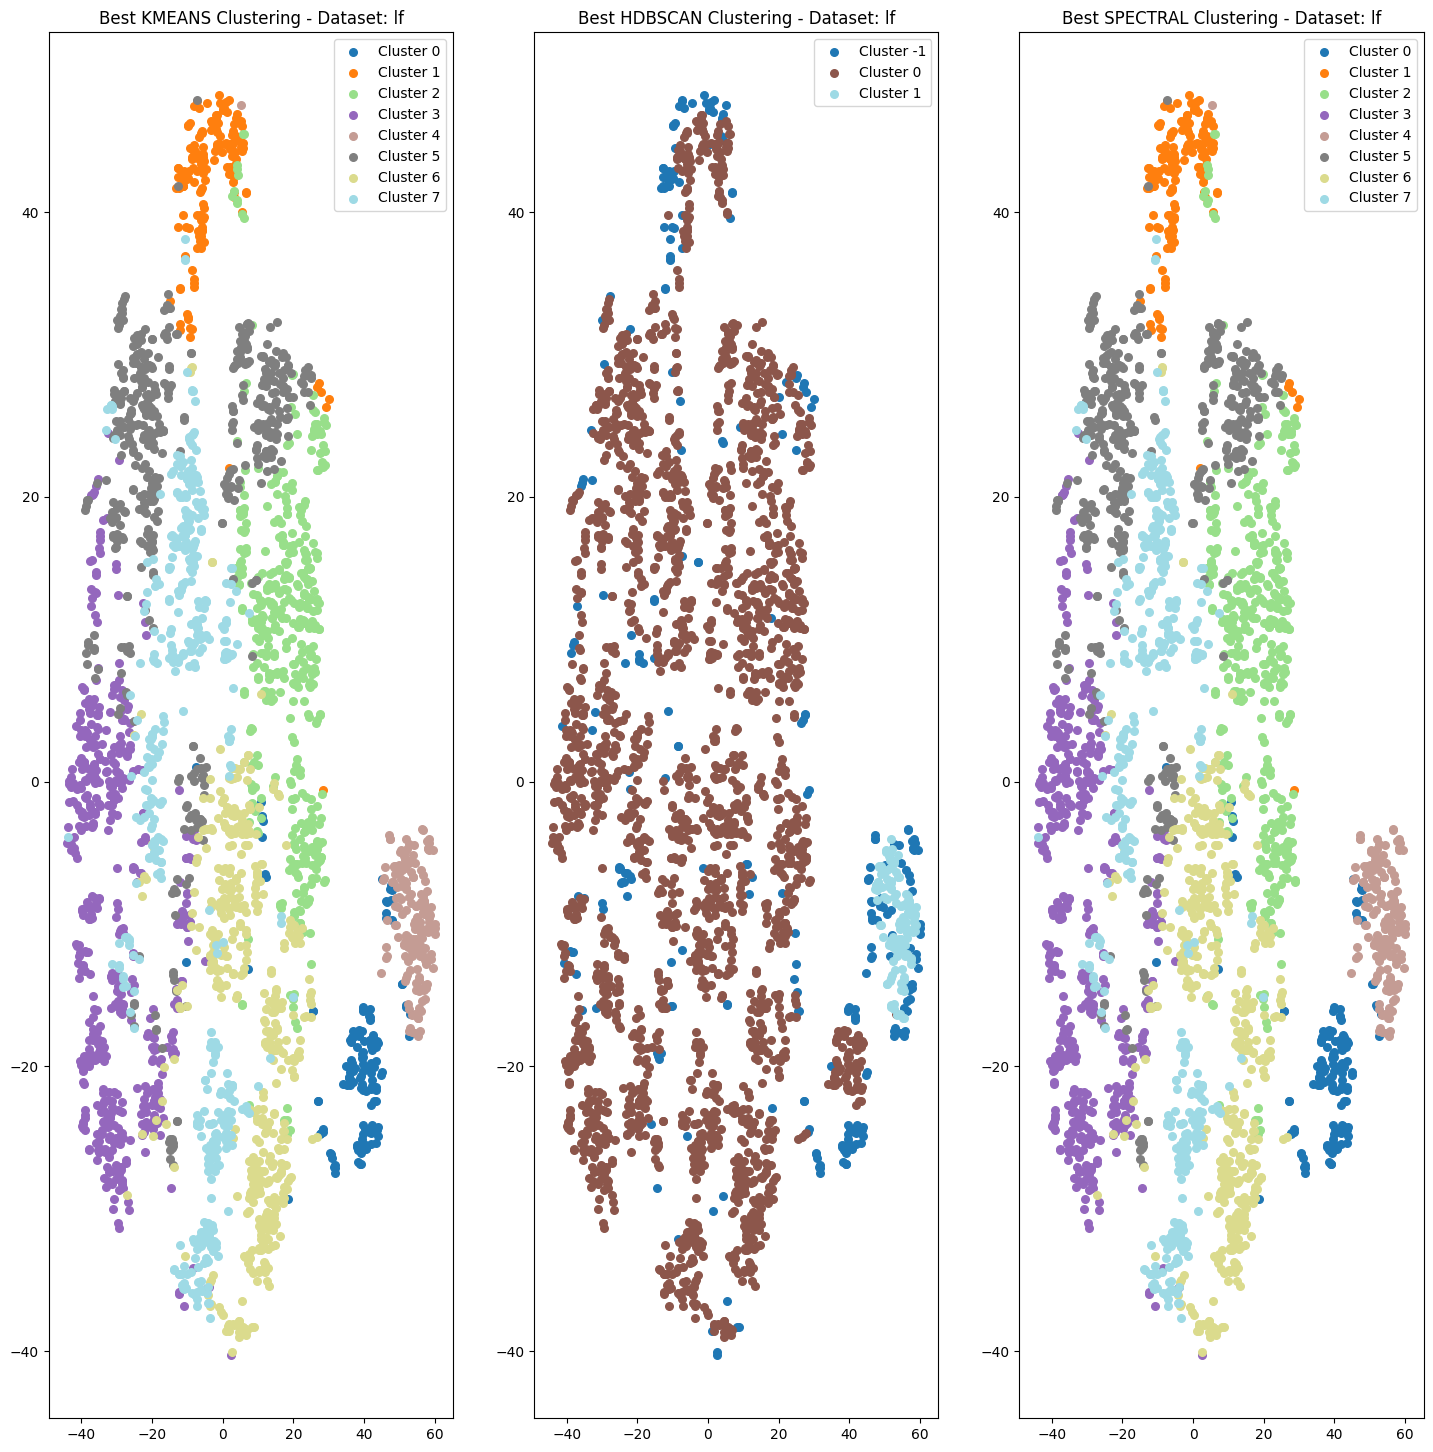

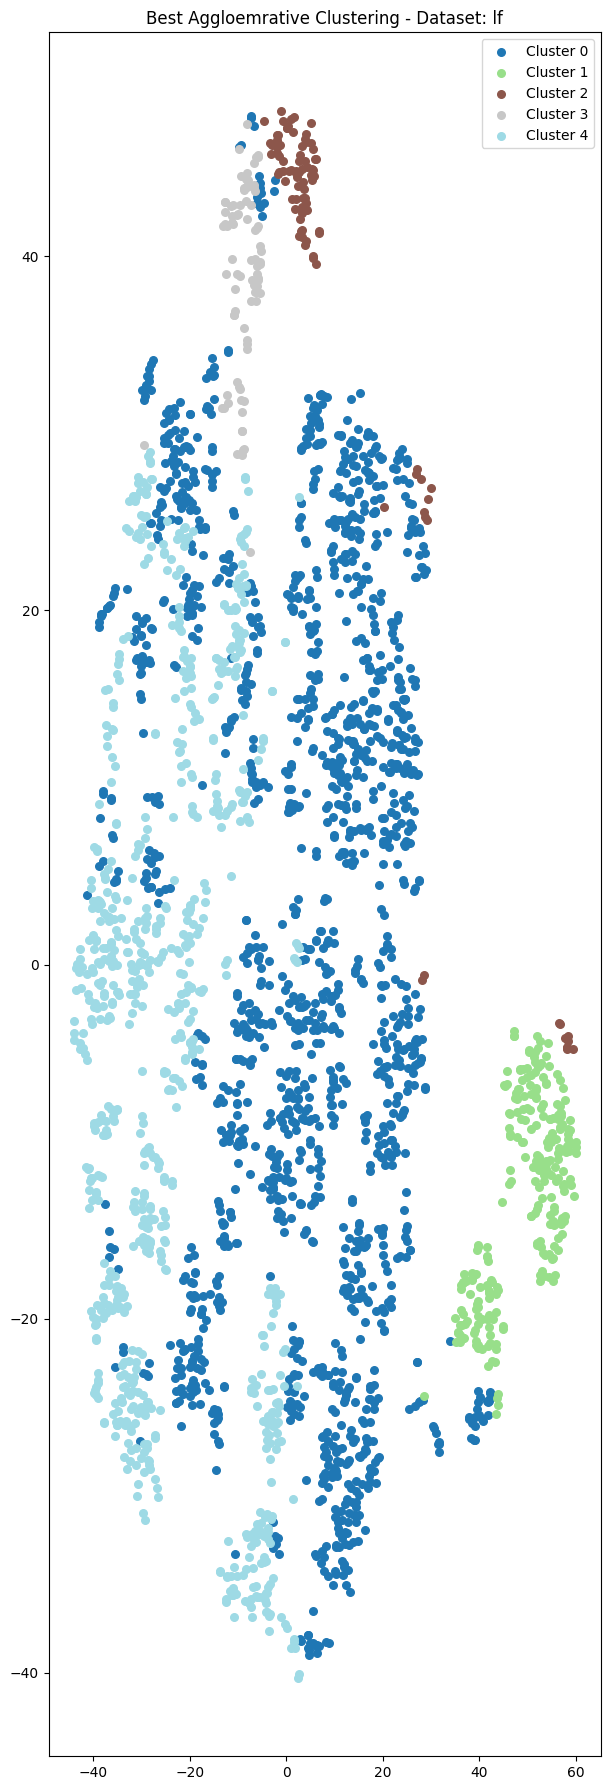

In [17]:
latent_late_fusion = Concatenate()([latent_ts, latent_st])
latent_late_fusion = np.array(latent_late_fusion)
data = [latent_st, latent_ts, latent_mm, latent_late_fusion]
#latent_st, latent_ts, latent_mm, latent_late_fusion
dataset_name = ['st', 'ts', 'mm', 'lf']
#'st', 'ts', 'mm', 'lf'
#'encoded_static', 'encoded_time_series', 
# data = [encoded_mm, encoded_late_fusion]

results = pd.DataFrame()
best_labels = pd.DataFrame()
all_labels = pd.DataFrame()
for i, y in zip(data, dataset_name):
    df_results, best_labels_, labels_df, best_model = clustering_helpers.compare_kmeans_hdbscan(i, dataset_name = y,  max_k=21)

    df_results.index = [y, y, y, y]

    y = f'{y}_{best_model}'
    labels_ = pd.Series(best_labels_, name=y)
    best_labels = pd.concat([best_labels, labels_], axis=1)
    all_labels = pd.concat([all_labels, labels_df], axis=1)
    

    #results = results.append(df_results)
    results = pd.concat([results, df_results])

In [18]:
results

,Model,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
st,KMeans,0.243994,1.246963,873.981122
st,HDBSCAN,0.384450,1.918312,410.141809
st,Spectral,0.243994,1.246963,873.981122
st,Agglomerative,0.267868,1.202864,658.155513
ts,KMeans,0.309638,1.240044,1246.220971
ts,HDBSCAN,0.154194,2.102885,452.291419
ts,Spectral,0.309638,1.240044,1246.220971
ts,Agglomerative,0.285921,1.294264,1134.371167
mm,KMeans,0.431150,0.836976,2578.101925
mm,HDBSCAN,0.501633,1.436873,1677.295254


In [20]:
best_labels.columns

Index(['st_HDBSCAN', 'ts_KMeans', 'mm_HDBSCAN', 'lf_HDBSCAN'], dtype='object')

In [ ]:
plt.style.use('default')
# Perform cluster stability analysis using Spectral
labels_ = ['mm_Agglomerative']
jaccard_indices_mm = clustering_helpers.cluster_stability(latent_mm, all_labels[labels_][labels_[0]].values, 20, 'hdbscan', num_iterations=100)
mean_jaccard_mm = np.mean(jaccard_indices_mm)

labels_ = ['lf_HDBSCAN']
# Perform cluster stability analysis using KMeans
jaccard_indices_lf = clustering_helpers.cluster_stability(latent_late_fusion, all_labels[labels_][labels_[0]].values, 3, 'hdbscan', num_iterations=100)
mean_jaccard_lf = np.mean(jaccard_indices_lf)

# Plotting ARI and Jaccard Index across the runs
plt.figure(figsize=(6, 6))
plt.plot(range(1, len(jaccard_indices_mm) + 1), jaccard_indices_mm, label="Jaccard Index MM, mean: {0:.2}".format(mean_jaccard_mm), marker='o')
plt.plot(range(1, len(jaccard_indices_lf) + 1), jaccard_indices_lf, label="Jaccard Index LF, mean: {0:.2}".format(mean_jaccard_lf) , marker='o')
plt.xlabel("Bootstrap Iteration")
plt.ylabel("Index Value")
plt.legend()
plt.tight_layout()

plt.show()

## KM

In [21]:
folder_sepsis = 'sepsis3_queries/data'
sepsis3 = pd.read_csv(f'{folder_sepsis}/sepsis-df-3.csv')
sepsis3 = sepsis3[sepsis3.sepsis_angus == 1]
sepsis3 = sepsis3.set_index('icustay_id')

In [22]:
all_labels.columns

Index(['st_KMeans', 'st_Spectral', 'st_HDBSCAN', 'st_Agglomerative',
       'ts_KMeans', 'ts_Spectral', 'ts_HDBSCAN', 'ts_Agglomerative',
       'mm_KMeans', 'mm_Spectral', 'mm_HDBSCAN', 'mm_Agglomerative',
       'lf_KMeans', 'lf_Spectral', 'lf_HDBSCAN', 'lf_Agglomerative'],
      dtype='object')

In [23]:
all_labels.index = sepsis3.index

mm_HDBSCAN  thirtyday_expire_flag
-1          0                         56
            1                         35
 0          0                         40
            1                          7
 1          0                        132
            1                         10
 2          0                        119
            1                         25
 3          0                        150
            1                         13
 4          0                         67
            1                         13
 5          0                        175
            1                         23
 6          0                         85
            1                         24
 7          0                         77
            1                         26
 8          0                        140
            1                         68
 9          0                        176
            1                         33
 10         0                         47
            1          

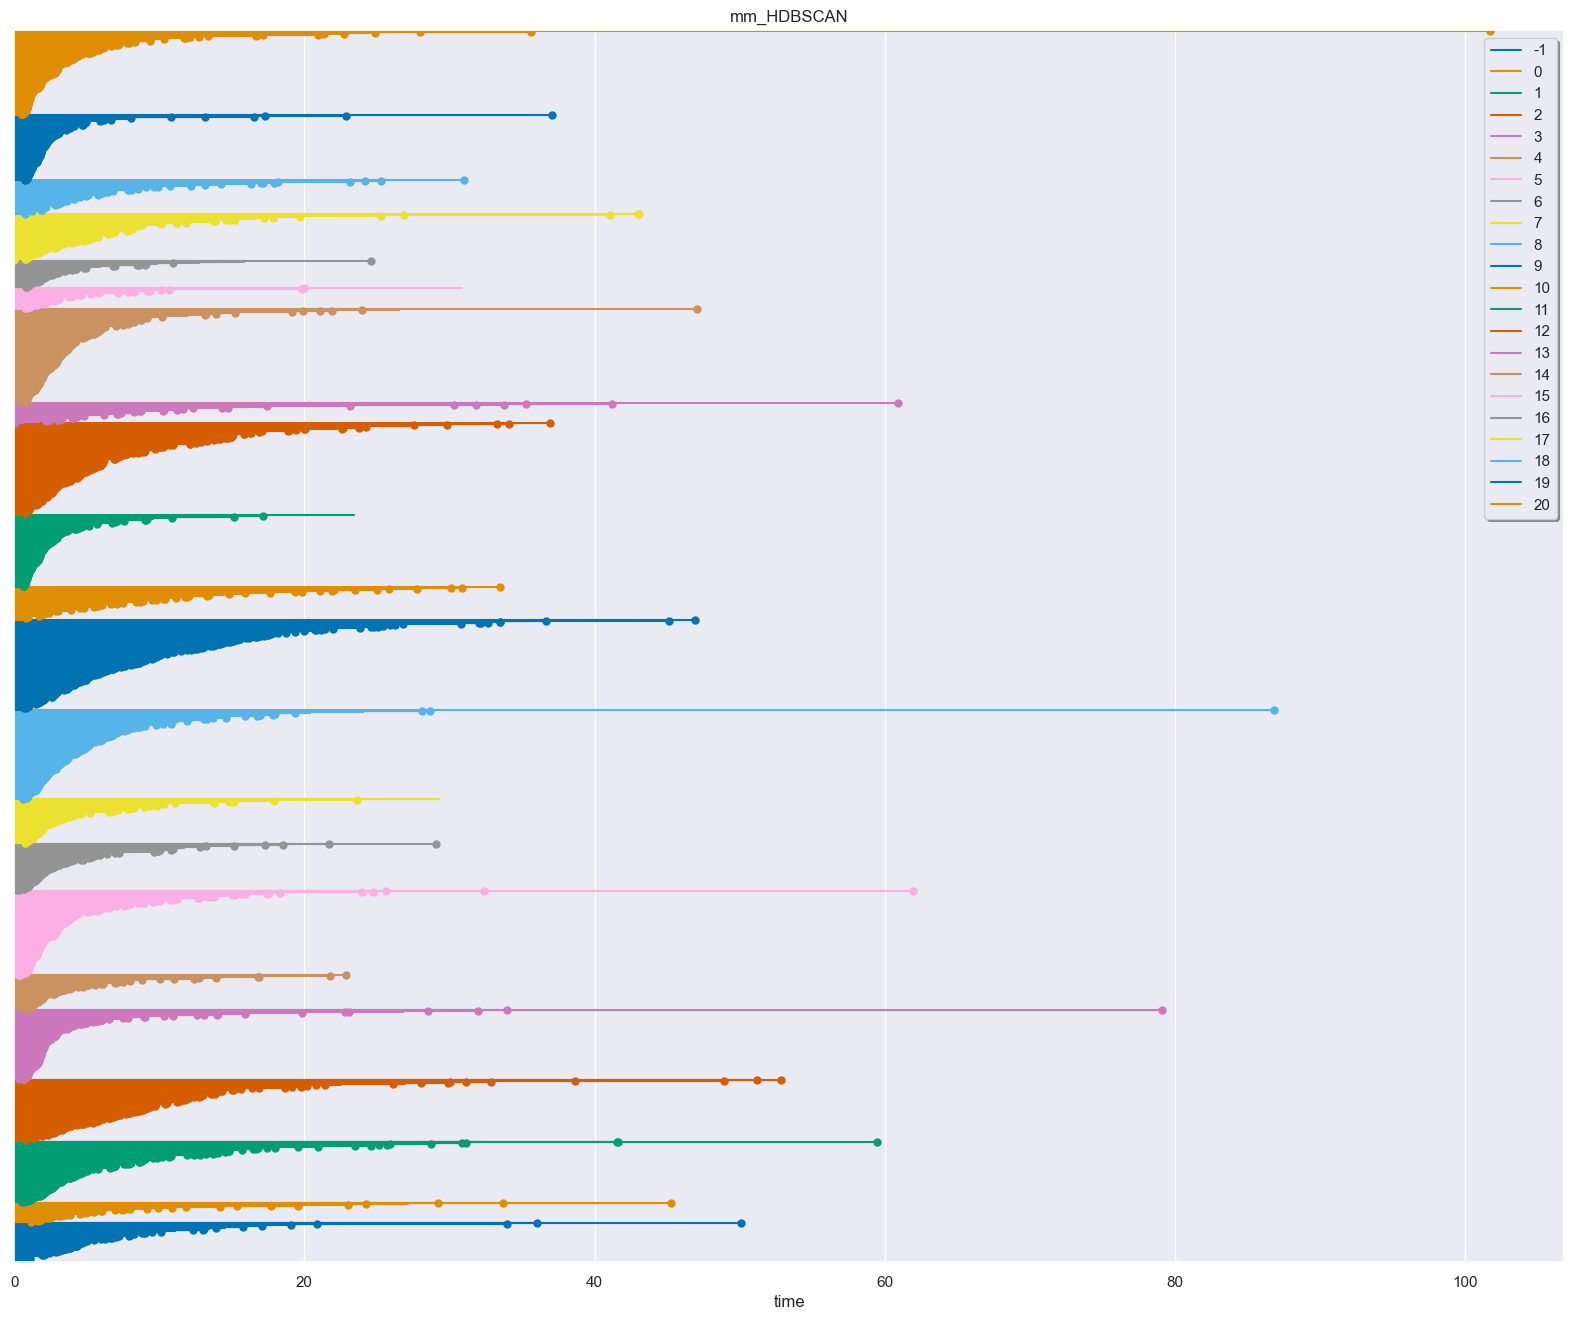

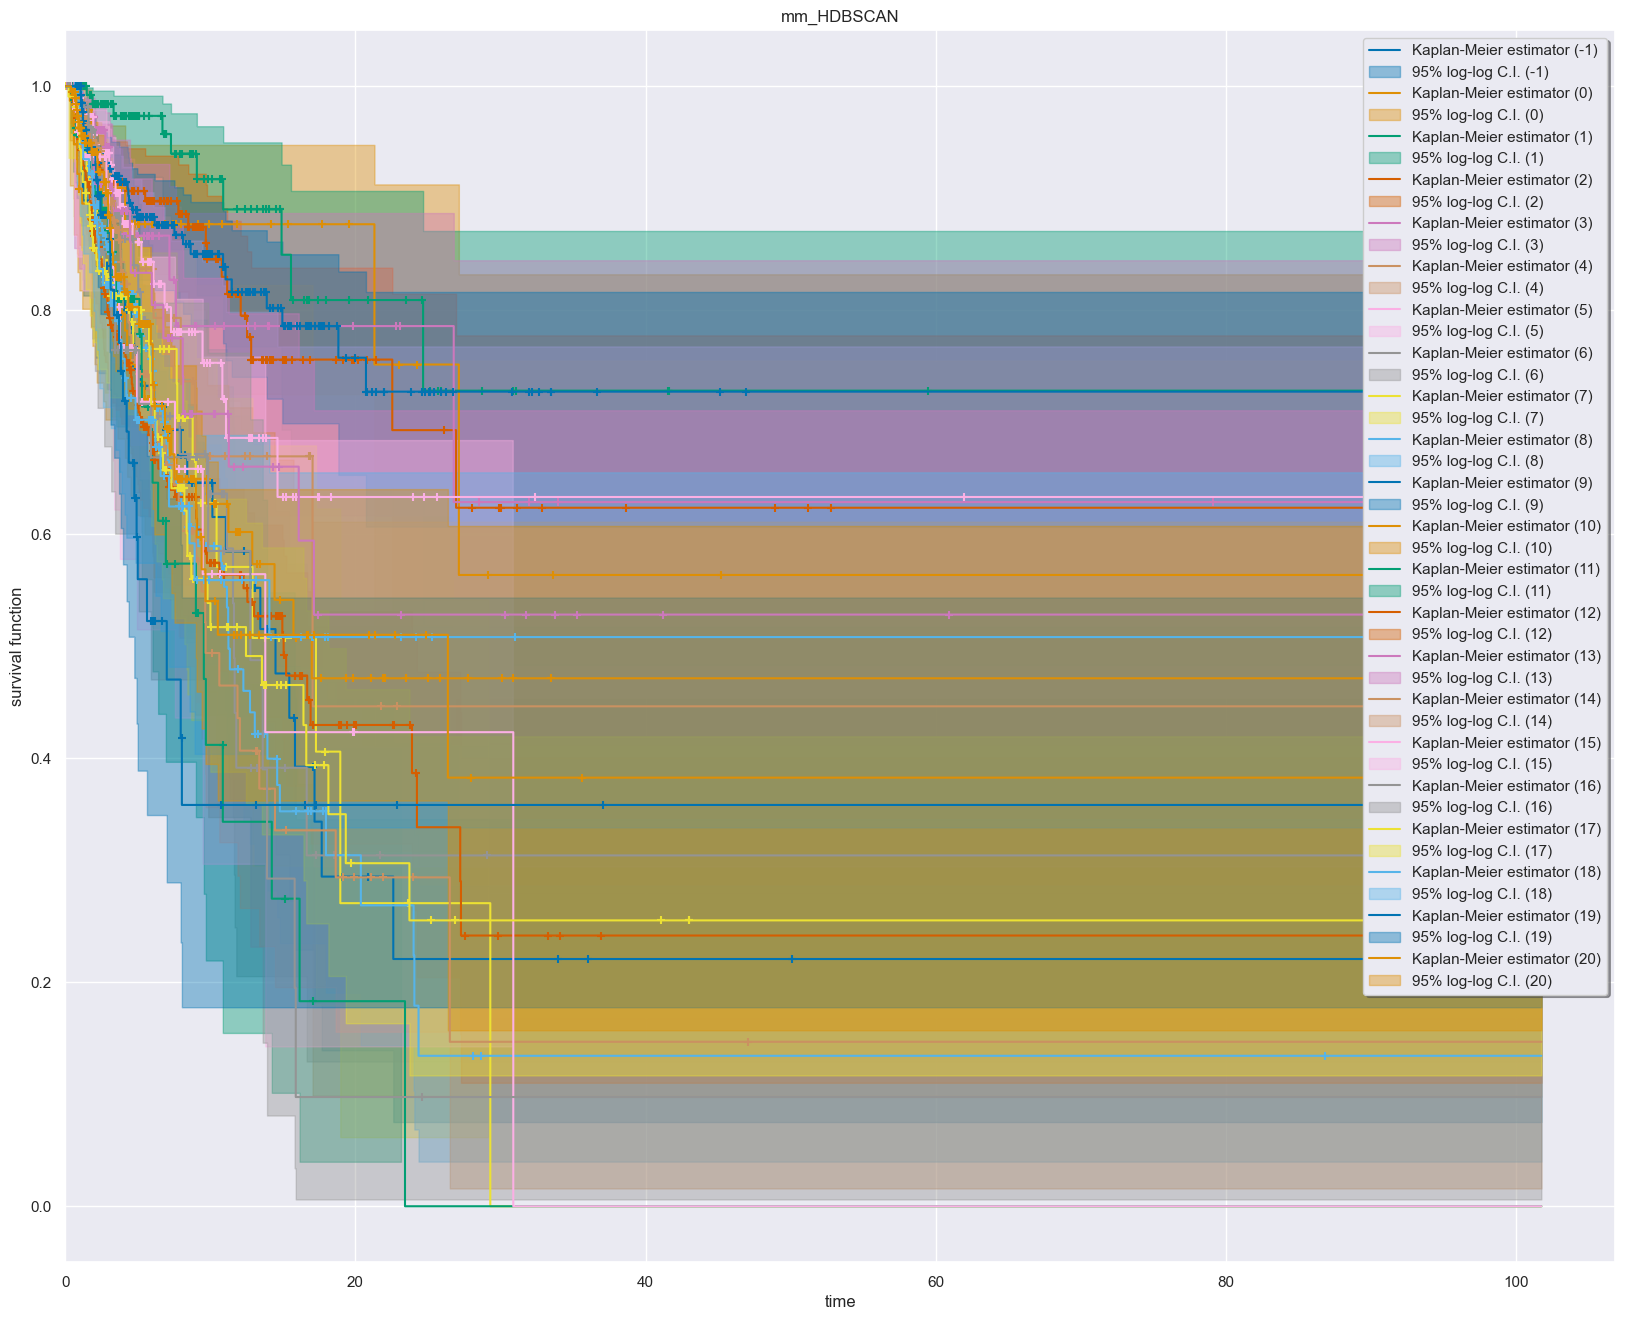

mm_HDBSCAN


group,-1,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
time,,,,,,,,,,,,,,,,,,,,,
1,0.955426,0.978723,1.000000,0.965130,0.993671,0.987342,0.989461,0.971504,0.960472,0.985290,...,0.956693,0.953046,0.956522,0.981153,0.959583,1.000000,0.962607,0.987013,1.000000,0.962305
3,0.827158,0.909273,0.984373,0.914916,0.946009,0.897029,0.940177,0.883854,0.829504,0.856749,...,0.871576,0.798200,0.913043,0.897748,0.906025,0.825336,0.824246,0.822511,0.885396,0.884642
5,0.750430,0.876799,0.973556,0.906365,0.866625,0.837227,0.860620,0.839967,0.765439,0.796585,...,0.810104,0.715166,0.833453,0.755204,0.718300,0.764200,0.800448,0.702240,0.597173,0.802878
10,0.646165,0.876799,0.916999,0.845504,0.785871,0.669552,0.753085,0.636263,0.627897,0.589377,...,0.411943,0.574602,0.707525,0.493961,0.564378,0.585091,0.538646,0.559016,0.358304,0.540271
30,0.220752,0.563657,0.728205,0.623670,0.628697,0.446368,0.633268,0.313237,0.000000,0.134324,...,0.000000,0.241714,0.528286,0.146826,0.423284,0.097515,0.255235,0.508196,0.358304,0.382692


In [24]:
labels_ = ['mm_HDBSCAN']


sns.set(style="darkgrid", palette="colorblind", color_codes=True)



for modality in labels_:
    kmd = sepsis3.join(all_labels[modality])
    surv = SurvivalData(time="icu_los", status="thirtyday_expire_flag", group=modality, data=kmd)
    print(kmd.groupby(modality)['thirtyday_expire_flag'].value_counts())

    #observed lifetimes of all the individuals in the data. Censored individuals are marked at the end of their lifespan.
    plt.figure(figsize=(20, 16))
    surv.plot_lifetimes()
    plt.title(modality)
    plt.show()
    plt.close()

    #kaplan meier
    km = KaplanMeier()
    km.fit(surv)

    #display(km.summary())
    # abulates the survival probability estimates and thier 
    # standard error and confidence intervals for the event times within each group. 
    # It can be printed to display all the information at once.
    #print(km.summary)
    plt.figure(figsize=(20, 16))
    km.plot()
    plt.title(modality)
    plt.show()
    plt.close()


    estimate = km.predict([1, 3, 5, 10, 30])
    # estimated probabiltiies for surviving past a certain time for each group.
    print(modality)
    display(estimate)

## Table 1

In [25]:
all_labels.columns

Index(['st_KMeans', 'st_Spectral', 'st_HDBSCAN', 'st_Agglomerative',
       'ts_KMeans', 'ts_Spectral', 'ts_HDBSCAN', 'ts_Agglomerative',
       'mm_KMeans', 'mm_Spectral', 'mm_HDBSCAN', 'mm_Agglomerative',
       'lf_KMeans', 'lf_Spectral', 'lf_HDBSCAN', 'lf_Agglomerative'],
      dtype='object')

In [26]:
from tableone import TableOne

ts_2d_df = pd.read_csv('preprocessing/representations/time_series_2d_angus.csv')
ts_2d_df = ts_2d_df.set_index('icustay_id')


hd_labels = all_labels[labels_]
hd_labels.index = ts_2d_df.index

temp = ts_2d_df.join(hd_labels)

table1 = TableOne(temp, dip_test=True, normal_test=True, tukey_test=True)
table1

/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


,,Missing,Overall
n,,,2867
"hours_in, n (%)",11.5,0,2867 (100.0)
"aado2, mean (SD)",,2328,448.9 (132.4)
"baseexcess, mean (SD)",,826,-2.3 (5.5)
"bicarbonate, mean (SD)",,6,22.5 (4.9)
"totalco2, mean (SD)",,826,23.8 (6.0)
"carboxyhemoglobin, mean (SD)",,2782,2.3 (1.7)
"chloride, mean (SD)",,6,105.1 (6.9)
"calcium, mean (SD)",,1542,1.1 (0.1)
"glucose, mean (SD)",,1,184.4 (2075.6)


In [27]:
nonnormal = list(temp.columns)
table2 = TableOne(temp, groupby= labels_,  nonnormal=nonnormal, pval = True, pval_adjust='bonferroni', smd=False,
                  htest_name=True)

table2

/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWa

Grouped by mm_HDBSCAN                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
                                                       Missing              Overall                   -1                    0                    1                   10                   11                   12                   13                   14                   15                   16                   17                   18                   19                    2                   20                    3                    4                    5                    6                    7                    8                    9 P-Value (adjusted)            Test
n                                                                              2867                   91                   47                  142                   77                  168                  214                   47                  219                   50                   63                  109                   78                  152                  144                  196                  163                   80                  198                  109                  103                  208                  209                                   
hours_in, median [Q1,Q3]            11.5                     0         2867 (100.0)           91 (100.0)           47 (100.0)          142 (100.0)           77 (100.0)          168 (100.0)          214 (100.0)           47 (100.0)          219 (100.0)           50 (100.0)           63 (100.0)          109 (100.0)           78 (100.0)          152 (100.0)          144 (100.0)          196 (100.0)          163 (100.0)           80 (100.0)          198 (100.0)          109 (100.0)          103 (100.0)          208 (100.0)          209 (100.0)              1.000     Chi-squared
aado2, median [Q1,Q3]                                     2328  472.0 [353.5,562.5]  465.0 [347.0,608.5]  414.5 [359.6,486.2]  379.0 [293.5,538.0]  490.9 [402.2,563.9]  474.0 [437.0,546.0]  469.0 [396.5,568.5]  482.0 [384.0,568.2]  523.5 [371.5,584.2]  507.5 [430.8,547.9]  619.0 [619.0,619.0]  442.2 [321.8,508.5]  462.5 [296.0,514.0]  459.0 [355.0,570.5]  464.0 [341.5,562.2]  491.5 [387.8,578.5]  490.0 [442.0,563.0]  578.6 [559.2,601.8]  457.0 [351.5,536.6]  564.2 [457.0,583.5]  371.0 [300.0,455.0]  453.0 [350.0,538.6]  489.0 [361.5,550.9]              1.000  Kruskal-Wallis
baseexcess, median [Q1,Q3]                                 826      -1.9 [-5.4,0.7]     -4.0 [-7.0,-0.0]     -3.3 [-6.0,-0.1]      -1.0 [-4.0,0.2]     -5.0 [-8.4,-1.0]      -2.5 [-5.0,0.2]      -1.4 [-4.7,1.0]     -4.8 [-7.9,-1.1]      -1.3 [-4.0,1.8]      -2.0 [-5.4,0.0]       0.0 [-3.1,2.0]      -1.2 [-5.0,1.0]      -2.1 [-6.4,0.5]      -1.0 [-4.5,0.0]      -2.6 [-6.5,0.4]      -1.0 [-4.2,1.0]      -2.2 [-5.8,0.5]      -4.9 [-7.1,0.0]      -1.7 [-5.0,1.0]      -1.5 [-6.0,0.5]      -1.0 [-4.6,1.1]      -1.2 [-4.8,1.8]      -1.0 [-4.2,1.1]             <0.001  Kruskal-Wallis
bicarbonate, median [Q1,Q3]                                  6     22.3 [19.5,25.3]     20.3 [17.7,23.5]     20.7 [17.8,24.3]     22.4 [19.3,25.2]     20.3 [18.1,23.6]     22.0 [19.9,24.7]     22.6 [20.0,25.3]     21.0 [17.5,23.3]     23.5 [21.0,26.5]     22.0 [19.7,24.9]     23.0 [20.6,25.5]     23.0 [19.5,26.6]     22.0 [19.0,25.2]     22.3 [20.0,24.5]     21.7 [18.6,24.5]     23.0 [20.5,26.0]     22.0 [18.8,24.7]     20.5 [17.4,23.4]     22.6 [20.0,25.0]     22.0 [19.4,24.3]     21.8 [19.3,24.6]     22.9 [20.0,26.8]     23.0 [20.5,26.0]          

In [28]:
t2 = table2.tableone
t2.columns = t2.columns.droplevel()
t2 = t2.replace(to_replace='<', value='', regex=True)

t2["P-Value (adjusted)"] = pd.to_numeric(t2["P-Value (adjusted)"], errors='coerce', downcast="float")

t2[t2['P-Value (adjusted)']<=0.05]

,,Missing,Overall,-1,0,1,10,11,12,13,14,...,20,3,4,5,6,7,8,9,P-Value (adjusted),Test
"baseexcess, median [Q1,Q3]",,826,"-1.9 [-5.4,0.7]","-4.0 [-7.0,-0.0]","-3.3 [-6.0,-0.1]","-1.0 [-4.0,0.2]","-5.0 [-8.4,-1.0]","-2.5 [-5.0,0.2]","-1.4 [-4.7,1.0]","-4.8 [-7.9,-1.1]","-1.3 [-4.0,1.8]",...,"-1.0 [-4.2,1.0]","-2.2 [-5.8,0.5]","-4.9 [-7.1,0.0]","-1.7 [-5.0,1.0]","-1.5 [-6.0,0.5]","-1.0 [-4.6,1.1]","-1.2 [-4.8,1.8]","-1.0 [-4.2,1.1]",0.001,Kruskal-Wallis
"bicarbonate, median [Q1,Q3]",,6,"22.3 [19.5,25.3]","20.3 [17.7,23.5]","20.7 [17.8,24.3]","22.4 [19.3,25.2]","20.3 [18.1,23.6]","22.0 [19.9,24.7]","22.6 [20.0,25.3]","21.0 [17.5,23.3]","23.5 [21.0,26.5]",...,"23.0 [20.5,26.0]","22.0 [18.8,24.7]","20.5 [17.4,23.4]","22.6 [20.0,25.0]","22.0 [19.4,24.3]","21.8 [19.3,24.6]","22.9 [20.0,26.8]","23.0 [20.5,26.0]",0.001,Kruskal-Wallis
"totalco2, median [Q1,Q3]",,826,"23.5 [20.0,27.0]","21.4 [18.4,24.5]","21.8 [18.2,24.4]","24.1 [21.0,27.0]","21.0 [19.1,24.8]","23.5 [20.0,26.1]","24.3 [20.9,27.0]","20.8 [18.3,23.5]","25.0 [20.9,28.9]",...,"24.0 [21.3,27.0]","23.2 [19.0,27.0]","20.8 [17.7,24.7]","23.0 [20.0,27.0]","23.0 [19.0,26.0]","24.2 [20.3,27.0]","24.0 [20.0,28.3]","24.2 [21.2,27.5]",0.001,Kruskal-Wallis
"chloride, median [Q1,Q3]",,6,"105.0 [101.0,109.0]","106.7 [103.4,110.5]","106.0 [101.3,111.0]","105.6 [102.3,109.0]","106.0 [101.3,109.3]","105.7 [101.4,109.0]","106.3 [103.5,109.8]","104.8 [101.2,108.6]","103.5 [99.5,107.0]",...,"104.0 [100.5,107.5]","105.5 [100.6,109.4]","105.5 [100.8,107.6]","101.7 [98.5,106.2]","104.0 [99.5,107.0]","108.3 [104.3,111.7]","105.6 [100.5,109.3]","105.8 [100.5,109.2]",0.001,Kruskal-Wallis
"calcium, median [Q1,Q3]",,1542,"1.1 [1.0,1.1]","1.1 [1.0,1.1]","1.1 [1.0,1.1]","1.1 [1.1,1.1]","1.1 [1.0,1.1]","1.1 [1.0,1.1]","1.1 [1.1,1.1]","1.1 [1.0,1.1]","1.1 [1.1,1.2]",...,"1.1 [1.1,1.2]","1.1 [1.0,1.1]","1.0 [1.0,1.1]","1.1 [1.0,1.1]","1.1 [1.0,1.1]","1.1 [1.1,1.2]","1.1 [1.1,1.2]","1.1 [1.1,1.1]",0.002,Kruskal-Wallis
"glucose, median [Q1,Q3]",,1,"133.7 [109.8,166.3]","132.0 [104.2,162.8]","132.7 [87.7,148.4]","134.5 [110.6,161.1]","134.1 [117.8,182.1]","133.3 [107.1,166.5]","138.4 [112.4,168.9]","151.3 [117.7,189.3]","135.8 [112.7,167.9]",...,"133.4 [111.2,162.8]","123.0 [105.2,157.3]","113.4 [98.9,154.8]","122.3 [103.1,154.9]","120.2 [105.0,160.0]","139.0 [111.2,174.7]","140.7 [115.0,173.5]","135.0 [112.1,162.5]",0.001,Kruskal-Wallis
"hematocrit, median [Q1,Q3]",,12,"31.9 [28.4,36.0]","31.4 [28.4,35.1]","30.2 [27.7,34.8]","34.8 [29.6,38.2]","34.8 [28.9,38.5]","30.3 [27.2,33.3]","32.8 [29.9,36.6]","31.7 [28.9,38.0]","31.5 [28.2,35.4]",...,"32.4 [28.9,36.5]","30.7 [27.7,34.2]","29.3 [26.0,33.5]","32.4 [28.0,35.9]","31.7 [27.5,35.7]","32.0 [28.4,36.1]","31.6 [28.7,35.1]","34.7 [30.2,39.9]",0.001,Kruskal-Wallis
"hemoglobin, median [Q1,Q3]",,14,"10.7 [9.4,12.1]","10.4 [9.1,11.5]","10.0 [9.2,11.9]","11.6 [9.7,12.9]","11.5 [9.7,13.0]","10.0 [8.8,11.1]","10.9 [9.8,12.2]","11.0 [9.6,12.3]","10.5 [9.3,11.7]",...,"10.8 [9.4,12.2]","10.3 [9.3,11.4]","10.0 [8.8,11.2]","11.0 [9.3,12.3]","10.7 [9.3,12.2]","10.6 [9.3,12.1]","10.4 [9.3,11.6]","11.7 [10.1,13.6]",0.001,Kruskal-Wallis
"lactate, median [Q1,Q3]",,396,"1.9 [1.4,2.8]","1.9 [1.5,3.2]","2.0 [1.4,4.0]","1.9 [1.2,2.8]","3.0 [1.8,5.2]","1.9 [1.2,2.6]","1.9 [1.3,3.0]","2.8 [1.9,4.7]","1.8 [1.4,2.5]",...,"1.7 [1.4,2.4]","1.8 [1.2,2.4]","2.0 [1.4,2.9]","1.7 [1.3,2.4]","2.2 [1.5,3.1]","2.1 [1.2,2.8]","1.7 [1.3,2.5]","1.9 [1.3,3.4]",0.001,Kruskal-Wallis
"so2, median [Q1,Q3]",,1798,"92.0 [80.2,97.0]","91.5 [81.0,95.8]","95.7 [92.2,97.4]","94.3 [89.4,97.8]","91.0 [83.0,96.5]","87.0 [76.0,95.8]","93.6 [81.6,97.0]","86.5 [77.2,93.0]","88.5 [73.8,95.4]",...,"86.0 [70.2,95.0]","86.0 [77.6,94.2]","82.0 [71.5,91.5]","90.2 [78.9,97.0]","86.3 [79.2,94.2]","93.0 [77.0,96.2]","94.0 [81.0,97.0]","93.0 [85.0,97.8]",0.001,Kruskal-Wallis


In [29]:
#static = static.set_index('icustay_id')
temp = static.join(hd_labels)


table = TableOne(temp, groupby= labels_, pval = True,pval_adjust='bonferroni', smd=False,
                  htest_name=True, display_all=True)
table 

/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWa

Grouped by mm_HDBSCAN                                                                                                                                                                                                                                                                                                                                   
                                                           Missing      Overall          -1           0            1          10           11           12          13           14          15          16           17          18           19            2           20            3           4            5            6            7            8            9 P-Value (adjusted)         Test
n                                                                          2867          91          47          142          77          168          214          47          219          50          63          109          78          152          144          196          163          80          198          109          103          208          209                                
vent, n (%)                              0.0                     0  1381 (48.2)   33 (36.3)   12 (25.5)    25 (17.6)     5 (6.5)   142 (84.5)     20 (9.3)    5 (10.6)   158 (72.1)   37 (74.0)   60 (95.2)    25 (22.9)   15 (19.2)   127 (83.6)      6 (4.2)   157 (80.1)   126 (77.3)   60 (75.0)   148 (74.7)    82 (75.2)    47 (45.6)    76 (36.5)     15 (7.2)             <0.001  Chi-squared
                                         1.0                        1486 (51.8)   58 (63.7)   35 (74.5)   117 (82.4)   72 (93.5)    26 (15.5)   194 (90.7)   42 (89.4)    61 (27.9)   13 (26.0)     3 (4.8)    84 (77.1)   63 (80.8)    25 (16.4)   138 (95.8)    39 (19.9)    37 (22.7)   20 (25.0)    50 (25.3)    27 (24.8)    56 (54.4)   132 (63.5)   194 (92.8)                                
F, n (%)                                 0.0                     0  1541 (53.7)   29 (31.9)   30 (63.8)    82 (57.7)  77 (100.0)               214 (100.0)  47 (100.0)                           63 (100.0)                           152 (100.0)               196 (100.0)                           198 (100.0)  109 (100.0)    44 (42.7)    91 (43.8)  209 (100.0)             <0.001  Chi-squared
                                         1.0                        1326 (46.3)   62 (68.1)   17 (36.2)    60 (42.3)              168 (100.0)                           219 (100.0)  50 (100.0)              109 (100.0)  78 (100.0)               144 (100.0)               163 (100.0)  80 (100.0)                              59 (57.3)   117 (56.2)                                             
M, n (%)                                 0.0                     0  1326 (46.3)   62 (68.1)   17 (36.2)    60 (42.3)              168 (100.0)                           219 (100.0)  50 (100.0)              109 (100.0)  78 (100.0)               144 (100.0)               163 (100.0)  80 (100.0)                              59 (57.3)   117 (56.2)                          <0.001  Chi-squared
                                         1.0                        1541 (53.7)   29 (31.9)   30 (63.8)    82 (57.7)  77 (100.0)               214 (100.0)  47 (100.0)                           63 (100.0)                           152 (100.0)               196 (100.0)                           198 (100.0)  109 (100.0)    44 (42.7)    91 (43.8)  209 (100.0)                                
adults, n (%)                            0.0                     0  1748 (61.0)   89 (97.8)     3 (6.4)      8 (5.6)     2 (2.6)  168 (100.0)  214 (100.0)  47 (100.0)  219 (100.0)  50 (100.0)  63 (100.0)  109 (100.0)  78 (100.0)  152 (100.0)      7 (4.9)  196 (100.0)      6 (3.7)     5 (6.2)      3 (1.5)      4 (3.7)  103 (100.0)  208 (100.0)     14 (6.7)             <0.001  Chi-squared
                                         1.0                        1119 (39.0)     2 (2.2)   44 (93.6)   134 (94.4)   75 (97.4)                 

In [30]:
all_labels[labels_].value_counts()

mm_HDBSCAN
 14           219
 12           214
 9            209
 8            208
 5            198
 20           196
 11           168
 3            163
 19           152
 2            144
 1            142
 6            109
 17           109
 7            103
-1             91
 4             80
 18            78
 10            77
 16            63
 15            50
 13            47
 0             47
dtype: int64

## DT

In [46]:
time_series_3d_df = pd.read_csv('preprocessing/representations/time_series_3d_angus.csv')
time_series_3d_df = time_series_3d_df.set_index('icustay_id')

In [47]:
static = static.astype(int)
columns = np.concatenate((static.columns, time_series_3d_df.columns), axis=None)
# Combine binary and continuous features
data = np.concatenate((static.values, time_series_3d_df.groupby('icustay_id').mean().values), axis=1)
mixed_data = pd.DataFrame(data, columns = columns)

In [48]:
sepsis3.columns

Index(['hadm_id', 'excluded', 'intime', 'outtime', 'dbsource',
       'suspected_infection_time_poe', 'suspected_infection_time_poe_days',
       'specimen_poe', 'positiveculture_poe', 'antibiotic_time_poe',
       'blood_culture_time', 'blood_culture_positive', 'age', 'gender',
       'is_male', 'ethnicity', 'race_white', 'race_black', 'race_hispanic',
       'race_other', 'metastatic_cancer', 'diabetes', 'height', 'weight',
       'bmi', 'first_service', 'hospital_expire_flag', 'thirtyday_expire_flag',
       'icu_los', 'hosp_los', 'sepsis_angus', 'sepsis_martin',
       'sepsis_explicit', 'septic_shock_explicit', 'severe_sepsis_explicit',
       'sepsis_nqf', 'sepsis_cdc', 'sepsis_cdc_simple', 'elixhauser_hospital',
       'vent', 'sofa', 'lods', 'sirs', 'qsofa', 'qsofa_sysbp_score',
       'qsofa_gcs_score', 'qsofa_resprate_score', 'composite_outcome',
       'blood culture', 'suspicion_poe', 'abx_poe', 'sepsis-3', 'sofa>=2'],
      dtype='object')

In [49]:
lab = best_labels[labels_]
mixed_data.index  = lab.index
df = mixed_data.join(lab)
df = df.fillna(-10)
#to_predict  = mort_icu.mort_icu

to_predict  = sepsis3.thirtyday_expire_flag
X, y = df.values, to_predict
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7, stratify=y)
clf = tree.DecisionTreeClassifier(random_state=42, max_depth=6)
clf = clf.fit(x_train, y_train)
scores = cross_val_score(clf, x_train, y_train, cv=10, scoring='f1_weighted')

scores

/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


array([0.75099807, 0.70936495, 0.74723545, 0.69427766, 0.73099305,
       0.69840743, 0.76448227, 0.76349781, 0.69098884, 0.74042443])

In [50]:
pd.DataFrame(clf.feature_importances_, index = df.columns, columns = ['FI']).sort_values(by='FI', ascending=False).head(30)

,FI
lactate,0.187584
urineoutput,0.144305
pt,0.103994
sodium,0.066381
platelet,0.047070
spo2,0.040510
inr,0.040155
seniors,0.039391
norepinephrine_dose,0.026699
baseexcess,0.026554


In [51]:
print("%0.2f f1 weighted with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.73 f1 weighted with a standard deviation of 0.03


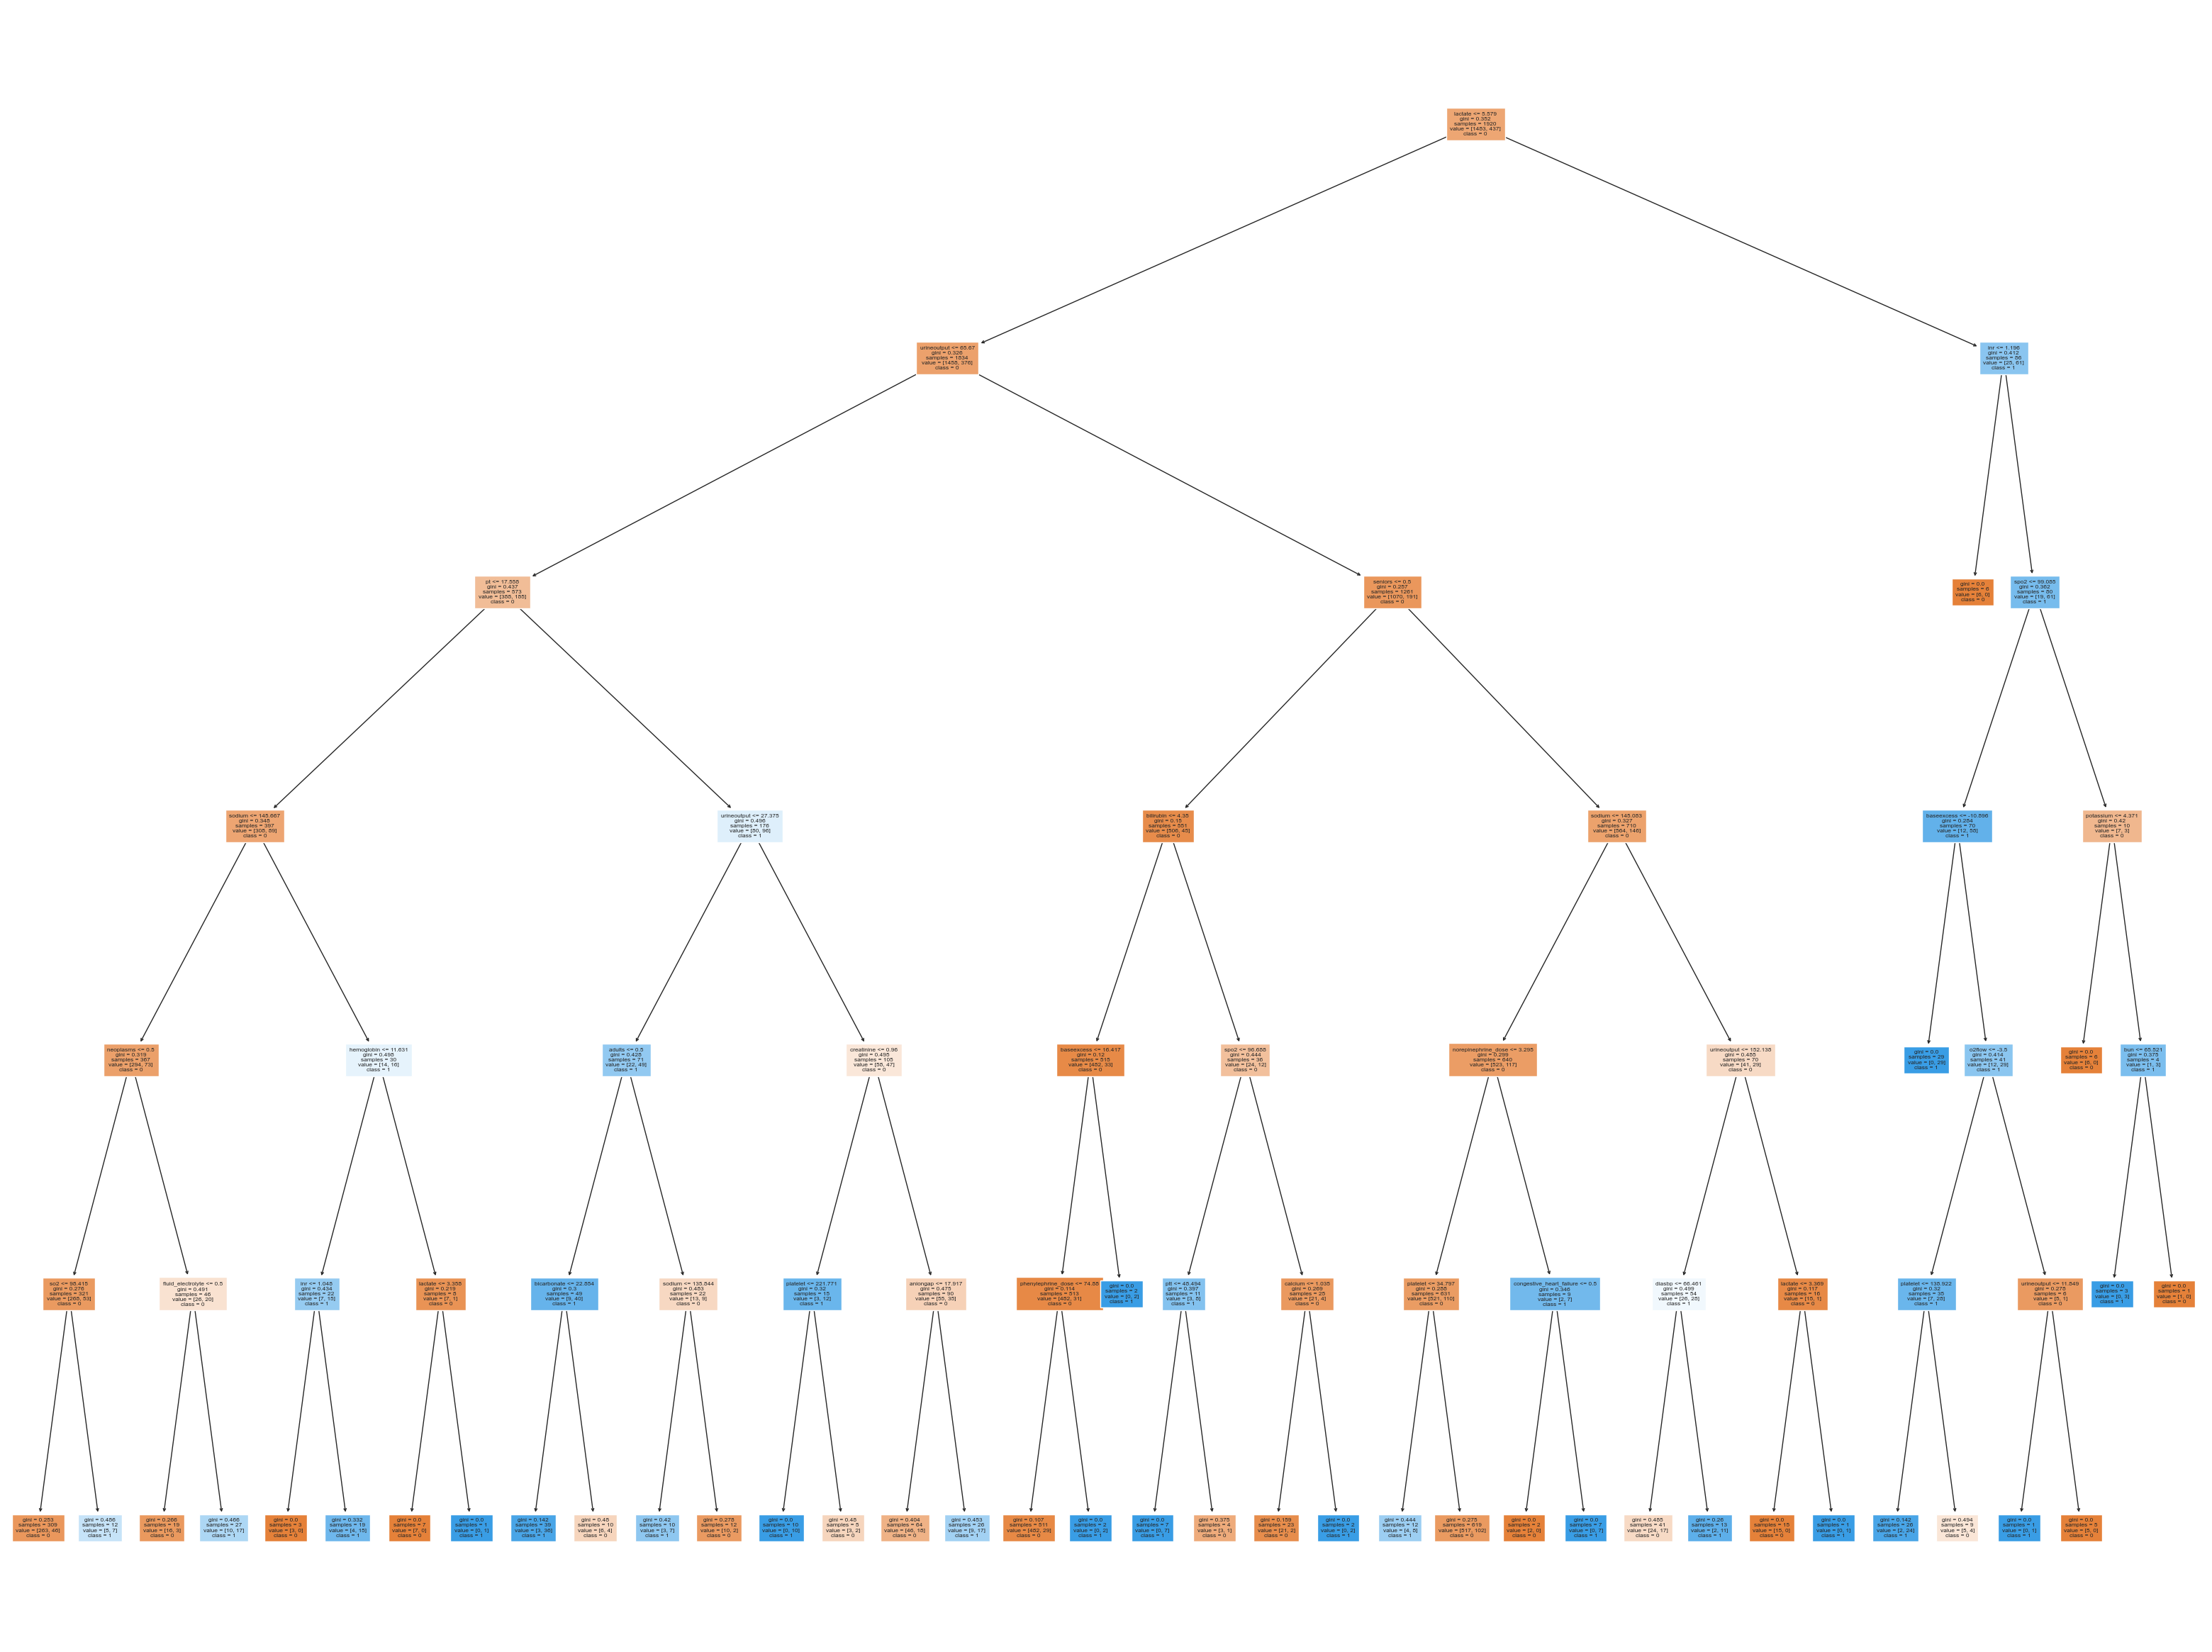

In [52]:
plt.figure(figsize=(40,30))
#c = ['-1','0','1','2','3']
#c = ['-1','0','1','2','3', '4','5','6','7','8','9','10','11', '12']

c = ['0','1']

tree.plot_tree(clf, filled=True, class_names=c, feature_names=df.columns, fontsize=6)
plt.show()